In [1]:
%run setup_Sv_compute.ipynb

# of files w/o bandwidth: 57
NB-VM-150         1088
OS-38              519
OS-75              363
WH-300             188
OS-150              26
NB-VM-300           25
NB-VM-75            14
BB-VM-150           13
OS-II-38             6
WH-Mariner-300       3
NB-DR-150            3
WH-1200              1
OS-II-75             1
DCP4400A             1
WH-Mariner-600       1
Name: instrument_name, dtype: int64


In [2]:
%run fxns_Sv_compute.ipynb

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from datetime import datetime
from datetime import time, timedelta
import itertools
from math import pi, cos, sin, acos
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import cm
from scipy.interpolate import interp1d
import warnings

In [4]:
warnings.filterwarnings('ignore')

# Get Tropical Pacific cruises only + map them

In [5]:
lat_abs_lim = 20
lon_w_lim = 120 # 120E, had 100E before but got too many Ind Oc
lon_e_lim = 285 # 75W 
df['in_tp'] = "" # 0 = in tropical pac, 1 = not
df.reset_index(inplace=True, drop=True)
for ifile in np.arange(0,len(df)):
    fname = df['fname'][ifile]
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    lon = nc['lon'].dropna(dim='time').values
    lat = nc['lat'].dropna(dim='time').values
    lon[lon<0] = lon[lon<0] + 360
    if (abs(lat) <= lat_abs_lim).any() and ((lon > lon_w_lim) & (lon < lon_e_lim)).any():
    # if any of the cruises profs are within the TP limits
        df.at[ifile,'in_tp'] = 1
    else:
        df.at[ifile,'in_tp'] = 0
dfnow = df[df['in_tp']==1]
# NOTE: skip ifile = 25 b/c that is weird DCP4400A instrument 
dfnow = dfnow[dfnow['instrument_name']!='DCP4400A']
# - Test
#pd.set_option('max_rows',10)
#dfnow['geo_region'].value_counts()
# --> dfnow looks good, but has a few Atl/Ind Oc files that are within the defined box
# - Old
#dfnow = df[df['geo_region'].notnull()]
#dfnow = dfnow[dfnow['geo_region'].str.contains('acific')]
dfnow.reset_index(inplace=True, drop=True)
fnamesnow = dfnow['fname'].values
print('# Tropical Pacific files:',len(fnamesnow))

# Tropical Pacific files: 547


In [6]:
%%script false --no-raise-error
fig = plt.figure(figsize=(12,12))
#ax0 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree(central_longitude=200))
ax0 = plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2, projection=ccrs.PlateCarree(central_longitude=200))
ax = ax0; exec(open("create_map_bgs.py").read()) # make map pretty
#for fname in np.concatenate((fnamesnow[0:10],fnamesnow[1000:1100])):
for fname in fnamesnow:
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    ax0.scatter(nc['lon'] ,nc['lat'], c='blue', s=0.5, alpha=0.1, transform=ccrs.PlateCarree());
    ax0.set_xlabel(''); ax0.set_ylabel(''); ax0.set_title('JASADCP Tropical Pacific cruises')
    #ax1 = plt.subplot(1, 3, 2)
    ax1 = plt.subplot2grid((3,2), (2,0))
    ax1.hist(dfnow['cruise_beg_date'].dt.year,
             bins=np.arange(dfnow['cruise_beg_date'].dt.year.min()-
                            0.5,dfnow['cruise_beg_date'].dt.year.max()+0.5), rwidth=0.8)
    ax1.set_title('JASADCP Tropical Pacific cruises years')
    ax1.set_xlabel('Year'); ax1.set_ylabel('# of cruises')
    #ax2 = plt.subplot(1, 3, 3)
    ax2 = plt.subplot2grid((3,2), (2,1))
    ax2.hist(dfnow['cruise_beg_date'].dt.month, bins=np.arange(0.5,13), rwidth=0.8)
    ax2.set_title('JASADCP Tropical Pacific cruises months')
    ax2.set_xlabel('Month'); ax2.set_ylabel('# of cruises')
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_info.png',
            bbox_inches='tight', pad_inches = 0, dpi = 200)

# Prepare variables and params

In [7]:
pg_thresh = 0 # % good pings threshold (get rid of pts w/ pg<pg_thresh)
lat_nmost = 20 
lat_smost = -20 
lon_w_wmost = 100 # 100 = 100E
lon_w_emost = 190 # 190 = 150W 
lon_e_wmost = 220 # 220 = 140W
lon_e_emost = 285 # 190 = 75W 
std_depths = np.arange(0,1000+25,25)
timemin = dfnow['cruise_beg_date'].min()
timemax = dfnow['cruise_beg_date'].max()
# Svcd = Sv cruise days
#Svcd_en_w = np.full([24,len(std_depths)], np.nan)
#Svcd_en_e = np.full([24,len(std_depths)], np.nan)
#Svcd_ln_w = np.full([24,len(std_depths)], np.nan)
#Svcd_ln_e = np.full([24,len(std_depths)], np.nan)
#Svcd_na_w = np.full([24,len(std_depths)], np.nan)
#Svcd_na_e = np.full([24,len(std_depths)], np.nan)
#Svcd_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e]
Svcd_all = [None,None,None,None,None,None]
Svcd_icd = np.asarray([0,0,0,0,0,0])

# Load/calc monthly ENSO time series

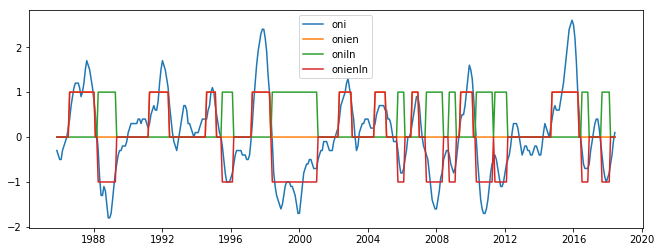

In [8]:
# - Load ONI 
dfoni = pd.read_csv(dpath+'oniindex1950_2018.txt',names=['Date','ONI']);
#dfoni.head(2)
# - Month fractions corresp to jan, feb, mar, etc. in the ONI txt file
monthfracs = [0,0.0834,0.1666,0.25,0.3334,0.4166,0.5,0.5834,0.6666,0.75,0.8334,0.9166];
# - Get ONI ts over desired timeframe
onibegmoidx = dfoni.index[dfoni['Date'] == (timemin.year + monthfracs[timemin.month-1])][0]
oniendmoidx = dfoni.index[dfoni['Date'] == (timemax.year + monthfracs[timemax.month-1])][0]
oni = dfoni['ONI'].iloc[onibegmoidx:(oniendmoidx+1)].values
onitime = pd.date_range(timemin.strftime('%Y-%m-01'), timemax.strftime('%Y-%m-01'), freq='MS') # should be 612 months long
# - Create EN/LN month classifications
onien = [0]*len(oni) # 1 = el nino month
oniln = [0]*len(oni) # 1 = la nina month
# - Classify El Nino months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]>=0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]<0.5:
        cmcounter=0;
    if cmcounter>=5:
        onien[imonth-cmcounter:imonth]=[1]*cmcounter;
# - Classify La Nina months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]<=-0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]>-0.5:
        cmcounter=0;
    if cmcounter>=5:
        oniln[imonth-cmcounter:imonth]=[1]*cmcounter;
# - Create everything to DataArrays
oni = xr.DataArray(oni, dims=('time'), coords={'time': onitime})
onien = xr.DataArray(onien, dims=('time'), coords={'time': onitime})
oniln = xr.DataArray(oniln, dims=('time'), coords={'time': onitime})
onienln = xr.zeros_like(onien, dtype='int')
onienln[onien==1] = 1 # el nino = 1
onienln[oniln==1] = -1 # la nina = -1
plotensoidx=1
if plotensoidx==1:
    fig = plt.figure(figsize=(11,4))
    plt.plot(onitime,oni)
    plt.plot(onitime,onien)
    plt.plot(onitime,oniln)
    plt.plot(onitime,onienln)
    plt.legend(["oni","onien","oniln","onienln"])

# Compile Sv cruise days

In [9]:
print(datetime.now().strftime("%H:%M:%S"))
for ifile in np.arange(0,len(fnamesnow)):

    # - Calculate Sv + get rid of times w/o lon and lat
    fname = fnamesnow[ifile]
    print(ifile,fname)
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    exec(open('calc_Sv.py').read()) # var calced = Sv
    
    # - Compute solar time
    solar_time = [None]*len(Sv['time'])
    for itime in range(0,len(Sv['time'])):
        lon = float(Sv_lon[itime])
        lat = float(Sv_lat[itime])
        utc_time = pd.to_datetime(Sv['time'].values[itime])
        solar_time[itime], _ = get_solar_time_and_angles(utc_time,lon,lat)
    Sv['time'] = solar_time; Sv_pflag['time'] = solar_time
    Sv_pg['time'] = solar_time; Sv_depth['time'] = solar_time
    Sv_lon['time'] = solar_time; Sv_lat['time'] = solar_time
    
    # - See how many days the cruise spans
    all_days = pd.to_datetime(Sv['time'].values).normalize().unique()
    print('# of days:',len(all_days))
    
    # - Append cruise day to appropriate matrix w/ standardized depths
    tot_cdays = len(all_days)
    daynow = pd.to_datetime(Sv['time'][0].values)
    for iday in range(0,tot_cdays):
        daynow = all_days[iday]
        daystrnow = daynow.strftime('%Y-%m-%d') 
        Svnow = Sv.where((Sv_pg>pg_thresh) & (Sv_pflag==0)).sel(time=daystrnow)
        Svhrnow = Svnow.groupby('time.hour').mean(dim='time') 
        Svdepthhrnow = Sv_depth.sel(time=daystrnow).groupby('time.hour').mean(dim='time')
        # - Standardize depths throughout
        Svhrnew = np.full([len(Svhrnow['hour']), len(std_depths)], np.nan)
        ihr = 0
        for hrnow in Svhrnow['hour']:
            old_depths = Svdepthhrnow.sel(hour=hrnow)
            old_Sv = Svhrnow.sel(hour=hrnow)
            good_idxs = np.where(~((std_depths>old_depths.max().values) | (std_depths<old_depths.min().values)))
            f = interp1d(old_depths, old_Sv)
            new_Sv = np.array([None]*len(std_depths))
            new_Sv[good_idxs] = f(std_depths[good_idxs])
            new_Sv = new_Sv.astype(float)
            Svhrnew[ihr,:] = new_Sv 
            ihr = ihr+1
        # - Append to appropriate matrix
        Svlonnow = Sv_lon.sel(time=daystrnow).mean()
        Svlatnow = Sv_lat.sel(time=daystrnow).mean()
        onitidxnow = (onienln['time'].dt.year==daynow.year) & (onienln['time'].dt.month==daynow.month)
        enlnnow = onienln[onitidxnow] # 1=EN, -1=LN, 0=nothing
        in_w = (Svlonnow>lon_w_wmost) & (Svlonnow<lon_w_emost) & (Svlatnow<lat_nmost) & (Svlatnow>lat_smost)
        in_e = (Svlonnow>lon_e_wmost) & (Svlonnow<lon_e_emost) & (Svlatnow<lat_nmost) & (Svlatnow>lat_smost)
        # Svcd_all order: Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e
        if in_w | in_e:
            if enlnnow==1: # EN
                midx = 0 if in_w else 1
            elif enlnnow==-1: # LN
                midx = 2 if in_w else 3
            elif enlnnow==0: # NA
                midx = 4 if in_w else 5
            Svcdnow = np.full([24, len(std_depths)], np.nan)
            Svcdnow[Svhrnow['hour'].values, :] = Svhrnew
            if Svcd_icd[midx]==0:
                Svcd_all[midx] = Svcdnow 
            else:
                Svcd_all[midx] = np.dstack([Svcd_all[midx], Svcdnow])
            Svcd_icd[midx] += 1
print(datetime.now().strftime("%H:%M:%S"))

06:04:28
0 00001_short.nc
# of days: 32
1 00002_short.nc
# of days: 36
2 00003_short.nc
# of days: 27
3 00004_short.nc
# of days: 42
4 00005_short.nc
# of days: 83
5 00006_short.nc
# of days: 31
6 00007_short.nc
# of days: 30
7 00008_short.nc
# of days: 16
8 00009_short.nc
# of days: 37
9 00012_short.nc
# of days: 36
10 00013_short.nc
# of days: 52
11 00014_short.nc
# of days: 50
12 00016_short.nc
# of days: 42
13 00017_short.nc
# of days: 19
14 00019_short.nc
# of days: 40
15 00020_short.nc
# of days: 43
16 00021_short.nc
# of days: 32
17 00022_short.nc
# of days: 32
18 00023_short.nc
# of days: 42
19 00024_short.nc
# of days: 18
20 00025_short.nc
# of days: 32
21 00029_short.nc
# of days: 7
22 00035_short.nc
# of days: 21
23 00036_short.nc
# of days: 31
24 00037_short.nc
# of days: 29
25 00078_short.nc
# of days: 2
26 00079_short.nc
# of days: 2
27 00080_short.nc
# of days: 23
28 00082_short.nc
# of days: 30
29 00083_short.nc
# of days: 25
30 00084_short.nc
# of days: 26
31 00085_sho

# Clean up + package Svcd variables

In [23]:
#Svcd_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e]
midxnow = 0
Svcd_enw_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
Svcd_enw_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_el_nino_WEP.nc')

midxnow = 1
Svcd_ene_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
Svcd_ene_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_el_nino_EEP.nc')

midxnow = 2
Svcd_lnw_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
Svcd_lnw_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nina_WEP.nc')

midxnow = 3
Svcd_lne_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
Svcd_lne_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nina_EEP.nc')

midxnow = 4
Svcd_naw_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
Svcd_naw_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nada_WEP.nc')

midxnow = 5
Svcd_nae_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
             coords={'hour': np.arange(0,24),
                     'depth': std_depths,
                     'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
Svcd_nae_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nada_EEP.nc')

# Averaging

In [88]:
#std_depths[0:29] goes from 0 to 700
Svcd_xr_plt = [Svcd_enw_xr, Svcd_ene_xr, Svcd_lnw_xr, Svcd_lne_xr, Svcd_naw_xr, Svcd_nae_xr]
Svcd_xr_plt_mean = [Svcd_enw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_ene_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_lnw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_lne_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_naw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_nae_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day')]
Svcd_xr_plt_title = ['EN west', 'EN east', 'LN west', 'LN east', 'NA west', 'NA east']

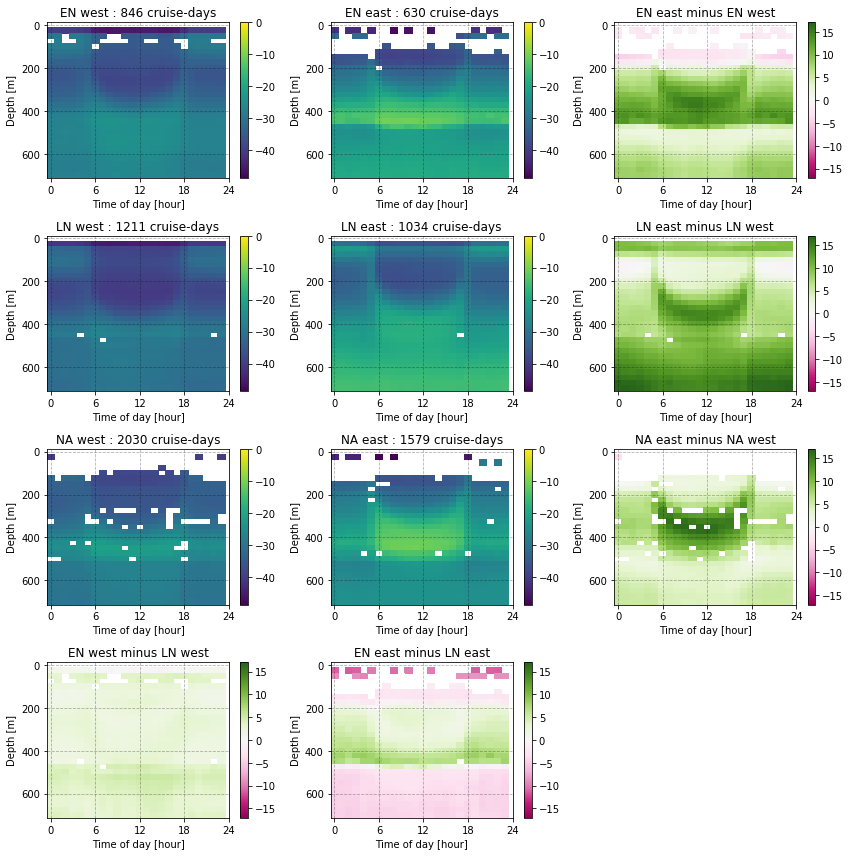

In [131]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
gridls = '--'
gridcolor = 'black'
gridalpha = 0.3
xticksnow = np.arange(0,30,6)
divcmapnow = cm.PiYG

isp = 0
arrnow = np.array(Svcd_xr_plt_mean)
#vmaxnow = np.nanmax(arrnow[~np.isinf(arrnow)])
vmaxnow = 0
vminnow = np.nanmin(arrnow[~np.isinf(arrnow)])
for yax in np.arange(0,3):
    for xax in np.arange(0,2):
        Svcd_xr_plt_mean[isp].plot(ax=axes[yax][xax], y='depth', yincrease=False, vmin=vminnow, vmax=vmaxnow)
        axes[yax][xax].set_xlabel('Time of day [hour]')
        axes[yax][xax].set_ylabel('Depth [m]')
        axes[yax][xax].set_title(Svcd_xr_plt_title[isp] + ': ' + str(Svcd_xr_plt[isp].shape[2]) + ' cruise-days')
        axes[yax][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
        axes[yax][xax].set_xticks(xticksnow)
        isp += 1

isp = 0
vminmaxnow = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_xr_plt_mean[isp+1]-Svcd_xr_plt_mean[isp]
    vminmaxnow = max(np.nanmax(abs(Svdiffnow.where(~np.isinf(Svdiffnow)))), vminmaxnow)
    isp += 2
isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_xr_plt_mean[isp]-Svcd_xr_plt_mean[isp+2]
    vminmaxnow = max(np.nanmax(abs(Svdiffnow.where(~np.isinf(Svdiffnow)))), vminmaxnow)
    isp += 1

isp = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_xr_plt_mean[isp+1]-Svcd_xr_plt_mean[isp]
    Svdiffnow.plot(ax=axes[yax][xax+1], y='depth', yincrease=False,
                   vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow)
    axes[yax][xax+1].set_xlabel('Time of day [hour]')
    axes[yax][xax+1].set_ylabel('Depth [m]')
    axes[yax][xax+1].set_title(Svcd_xr_plt_title[isp+1] + ' minus ' + Svcd_xr_plt_title[isp])
    axes[yax][xax+1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax][xax+1].set_xticks(xticksnow)
    isp += 2

isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_xr_plt_mean[isp]-Svcd_xr_plt_mean[isp+2]
    Svdiffnow.plot(ax=axes[yax+1][xax], y='depth', yincrease=False,
                   vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow)
    axes[yax+1][xax].set_xlabel('Time of day [hour]')
    axes[yax+1][xax].set_ylabel('Depth [m]')
    axes[yax+1][xax].set_title(Svcd_xr_plt_title[isp] + ' minus ' + Svcd_xr_plt_title[isp+2])
    axes[yax+1][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax+1][xax].set_xticks(xticksnow)
    isp += 1
axes[3,2].axis('off')
fig.tight_layout()

# PCA

In [ ]:
# CONTINUE HERE!!!!!
# - old
#Sv_pca0 = Sv.fillna(Sv.min())
#print(np.sum(np.isnan(Sv_pca0.values)))
#Sv_pca0 = Sv_filled.resample(time='1H').mean()
#print(np.sum(np.isnan(Sv_pca0)))
all_days = pd.to_datetime(Sv['time'].values).normalize().unique()
tot_cdays = len(all_days)
daynow = pd.to_datetime(Sv['time'][0].values)
Sv_pca = None
for iday in range(0,tot_cdays):
    daynow = all_days[iday]
    day_strnow = daynow.strftime('%Y-%m-%d') 
    Svhrnow = Sv_pca0.sel(time=day_strnow).groupby('time.hour').mean(dim='time')
    #print(Svhrnow.shape)
    #print(np.sum(np.isnan(Svhrnow.values)))
    #print(np.sum(np.isinf(Svhrnow.values)))
    if Svhrnow.shape[0]==24:
        if Sv_pca is None:
            Sv_pca = Svhrnow.values.ravel()
        else:
            Sv_pca = np.vstack([Sv_pca, Svhrnow.values.ravel()])
print(np.sum(np.isnan(Sv_pca)))
print(np.sum(np.isinf(Sv_pca)))

In [ ]:
x = np.arange(0, array.shape[1])
y = np.arange(0, array.shape[0])
#mask invalid values
array = np.ma.masked_invalid(array)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')

In [116]:
Svcdnow = Svcd_enw_xr

In [117]:
Sv_pca = None

In [126]:
meannow = Svcdnow.mean(dim='cruise_day')
meanvnow = meannow.values

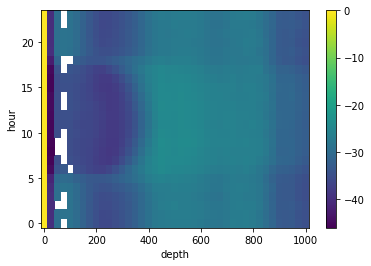

In [130]:
meannow.fillna(0).plot()

In [127]:
print(np.sum(np.isnan(meannow.values)))
print(np.sum(np.isinf(meannow.values)))

24
18


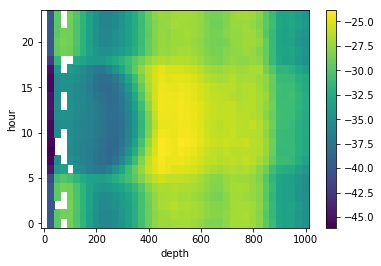

In [128]:
meannow.plot()

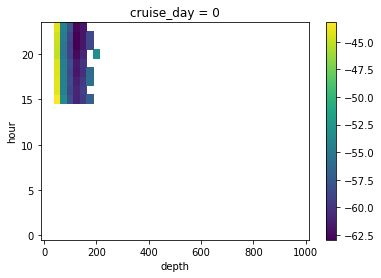

In [118]:
slicenow = Svcdnow[:,:,0]
slicenow.plot()

In [114]:
for icd in np.arange(0,Svcdnow.shape[2]):
    slicenow = Svcdnow[:,:,icd]
    if Sv_pca is None:
        Sv_pca = slicenow.values.ravel()
    else:
        Sv_pca = np.vstack([Sv_pca, Slicenow.values.ravel()])

IndexError: tuple index out of range

In [ ]:
u, s, v = np.linalg.svd(Sv_pca.transpose())

In [ ]:
num_days = Sv_pca.shape[0]
num_depth_cells = Sv_pca0.shape[1]

In [ ]:
for ieof in np.arange(0,3): 
    uf = u[:,ieof].reshape((24,num_depth_cells))
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
    pc = ax.pcolormesh(np.arange(0,24),Sv_depth_arr,uf.transpose())
    ax.set_ylim([Sv_depth_arr.max(),0])
    plt.colorbar(pc, ax=ax)

In [ ]:
from matplotlib.ticker import AutoMinorLocator
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,2))
for ieof in np.arange(0,3):
    ax.plot(v[:,ieof],label=str(ieof))
    ax.plot([0,num_days],[0,0],'k--')
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Edge detection + averaging

# Edge detection + PCA

In [ ]:
#conda install -c conda-forge scikit-image

In [ ]:
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html
from scipy import ndimage as ndi
from skimage import feature

In [ ]:
u0 = 10000*u[:,0].reshape((24,num_depth_cells))
u1 = 10000*u[:,0].reshape((24,num_depth_cells))
edges1 = feature.canny(u0, sigma = 1)
edges2 = feature.canny(u0, sigma = 2)
edges3 = feature.canny(u1, sigma = 1)
edges4 = feature.canny(u1, sigma = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(15, 3),
                                    sharex=True, sharey=True)
ax1.pcolormesh(u1)
ax2.pcolormesh(edges1, cmap=plt.cm.gray)
ax3.pcolormesh(edges2, cmap=plt.cm.gray)
ax4.pcolormesh(edges3, cmap=plt.cm.gray)
ax5.pcolormesh(edges4, cmap=plt.cm.gray)
fig.tight_layout()